# Rigorous Thermodynamic Decomposition of Salt Effects on the Polymerization of Polyethylene Glycol
Stefan Hervø-Hansen<sup>a,*</sup>, Kazuo Yamada<sup>a,*</sup>, Jan Heyda<sup>b,*</sup>, and Nobuyuki Matubayasi<sup>a,*</sup>.<br><br>
<sup>a</sup> Division of Chemical Engineering, Graduate School of Engineering Science, Osaka University, Toyonaka, Osaka 560-8531, Japan.<br>
<sup>b</sup> Department of Physical Chemistry, University of Chemistry and Technology, Prague CZ-16628, Czech Republic.<br>
<sup>*</sup> To whom correspondence may be addressed: stefan@cheng.es.osaka-u.ac.jp, k.yamada@cheng.es.osaka-u.ac.jp, heydaj@vscht.cz, and nobuyuki@cheng.es.osaka-u.ac.jp.

## Part 2: Analysis


### Introduction


### Methods & Materials
Molecular dynamics simulations are conducted using the openMM (7.7.0)[<sup>2</sup>](#fn2) software package modded with the openmmtools[<sup>3</sup>](#fn3) and parmed[<sup>4</sup>](#fn4) packages. For the simulation of PEG a CHARMM derived force field (C35r) was utilized, which has previously been able to reproduce hydrodynamic radii and shape anisotropy of PEG.[<sup>5</sup>](#fn5) The PEG force field was employed in combination with the SPC/E force field for water[<sup>6</sup>](#fn6) and optimized ion parameters for sodium thiocyanate and sodium chloride.
The isothermal-isobaric ensemble will be sampled using a combination of a geodesic Langevin integrator[<sup>8</sup>](#fn8) and a Monte Carlo barostat[<sup>9,</sup>](#fn9)[<sup>10</sup>](#fn10). The trajectories was analyzed using MDtraj[<sup>11</sup>](#fn11) for structural properties, while ERmod[<sup>12</sup>](#fn12) be utilized for the calculation of solvation free energies and can be found in the [Part 2 Jupyter notebook](Analysis.ipynb).

### References
2. <span id="fn2"> Eastman P, et al. (2017) OpenMM 7: Rapid development of high performance algorithms for molecular dynamics. PLOS Computational Biology 13(7):e1005659.</span><br>
3. <span id="fn3"> https://github.com/choderalab/openmmtools</span><br>
4. <span id="fn4"> https://github.com/ParmEd/ParmEd </span><br>
5. <span id="fn5"> Lee H, Venable RM, Mackerell Jr AD, Pastor RW (2008) Molecular dynamics studies of polyethylene oxide and polyethylene glycol: hydrodynamic radius and shape anisotropy. Biophys J. 95(4):1590-1599. </span><br>
6. <span id="fn6"> Berendsen HJC, Grigera JR, Straatsma TP (1987) The missing term in effective pair potentials. The Journal of Physical Chemistry 91(24):6269–6271. </span><br>
8. <span id="fn8"> Leimkuhler B, Matthews C (2016) Efficient molecular dynamics using geodesic integration and solvent–solute splitting. Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences 472(2189):20160138. </span><br>
9. <span id="fn9"> Chow K-H, Ferguson DM (1995) Isothermal-isobaric molecular dynamics simulations with Monte Carlo volume sampling. Computer Physics Communications 91(1–3):283–289. </span><br>
10. <span id="fn10"> Åqvist J, Wennerström P, Nervall M, Bjelic S, Brandsdal BO (2004) Molecular dynamics simulations of water and biomolecules with a Monte Carlo constant pressure algorithm. Chemical Physics Letters 384(4–6):288–294. </span><br>
11. <span id="fn11"> McGibbon RT, et al. (2015) MDTraj: A Modern Open Library for the Analysis of Molecular Dynamics Trajectories. Biophysical Journal 109(8):1528–1532. </span><br>
12. <span id="fn12"> Sakuraba S, Matubayasi N (2014) Ermod: Fast and versatile computation software for solvation free energy with approximate theory of solutions. Journal of Computational Chemistry 35(21):1592–1608. </span><br>


## Import of Python Modules & Auxiliary Functions

In [14]:
#Notebook dependent libs
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import mdtraj as md
import parmed as pmd
import os, time, re, yaml, string
import scipy.stats as stats

from Auxiliary import fessa
plt.set_cmap('fessa')

kcal_to_kT = 1.688 # Assuming 298.15 K

ERMODHOME = '/home/stefan/ermod-0.3.7'
homedir = !pwd
homedir = homedir[0]
print(homedir)

/data/stefan/PEO-Solubility


<Figure size 432x288 with 0 Axes>

### Simulation settings

In [10]:
# State of simulations, (outFreq is steps per frame)
states = {                                                               
          'sol': {'Nsteps': 50000000,  'OutFreq': 2500}, # 100 nanoseconds, 20000 frames
          'ref': {'Nsteps': 500000,    'OutFreq':  500}, #   1 nanoseconds,  1000 frames
         }                                                          
          
nmers = [2, 4, 6, 8, 15, 36]

salts = {'No_salt': {'Cation': 'No_', 'Anion': 'salt' },
#         'NaCl'   : {'Cation': 'Na' , 'Anion': 'Cl'   },
#         'CsCl'   : {'Cation': 'Cs' , 'Anion': 'Cl'   },
#         'NaSCN'  : {'Cation': 'Cs' , 'Anion': 'SCN'  },
#         'CsSCN'  : {'Cation': 'Cs' , 'Anion': 'SCN'  },
        }

# Approximate concentrations of salts with
concentrations = {0.00: {'PEG': 1, 'Water': 3000, 'Cation': 0,   'Anion': 0},
                  1.00: {'PEG': 1, 'Water': 3000, 'Cation': 54,  'Anion': 54},
                  2.00: {'PEG': 1, 'Water': 3000, 'Cation': 109, 'Anion': 109},
                 }

#* Calculated by hand *#
# Cube length ≈ 45 Ångstroms. Round up to 50 and then adjust to correct volume with barostat.

## Analysis
### Prepare ERmod analysis
<img style="float: right;width:319.5px;height:312.5px;" src="Figures/ermod.png" title="ERmod analysis flow" >

The determination of solvation free energies and chemical potentials though the ERmod software is conducted in two stages as illustrated in the figure. First is the determination of the energy distribution functions from the simulation trajectories obtained from molecular dynamics using the subprogram `ermod`. Second is the solvation free energy is determined from the energy distribution functions though an approximate functional using the subprogram `slvfe`.

Documentation for the parameter file `parameters_er` which determines how the `ermod` subprogram runs can be found [here](https://sourceforge.net/p/ermod/wiki/parameters-ermod03/). In the python code below it can be noted many of the parameters has been given the keyword `[correct]`, these settings are dependent on the simulation settings and or the software being used and are thus recommended not to be changed if using the openMM setup above. The parameters given the keyword `[to be set]` are settings either collected from the output of the openMM script or set by the user, in specific the values for `maxins` and `engdiv` should be given by the user are given the default value of 1000 and 5 respectively.

Documentation for the parameter file `parameters_fe` which determines how the `slvfe` subprogram runs can be found [here](https://sourceforge.net/p/ermod/wiki/parameters-slvfe/). It is recommended not to change the parameters in this file with the exception of the temperature if conducting simulations at other temperatures than 298.15 Kelvin, and the volume. In the code below the average volume input is calculated as an average volume from the two ensemble volume averages.

In [ ]:
# ERmod settings
state_parameters = {
    'refs': {'state': 3, 'Ninserts': 5000, 'Ndivisions': 5},
    'soln': {'state': 1, 'Ninserts': 5000, 'Ndivisions': 10}
}

ermod_script = """
&ene_param
      slttype = {state},     ! Choose system; 1: Solution system  2,3: Reference                     [to be set]
      boxshp = 1,            ! Boxtype                                                               [correct]   
      estype = 2,            ! Ensemble; 1: NVT   2: NPT                                             [correct]   
      inptemp = 298.15,      ! Temperature (in Kelvin)                                               [correct]   
      ljformat = 2,          ! LJ form                                                               [correct]   
      cmbrule = 1,           ! Combination rule                                                      [correct]   
      ljswitch = 1,          ! Switching function for smooth LJ truncation                           [correct]   
      upljcut = 12,          ! Upper limit for LJ cutoff switching function (in Angstrom)            [correct]   
      lwljcut = 10,          ! Lower limit for LJ cutoff switching function (in Angstrom)            [correct]   
      cltype = 2,            ! Treatment of Coulomb interaction (2=PME)                              [correct]   
      elecut = 12.0,         ! Cutoff of the real-space electrostatic interaction (in angstrom)      [correct]   
      ewtoler = 0.00001,     ! Error tolerance in Ewald                                              [correct]   
      splodr = 5,            ! Order of spline function used in PME                                  [correct]   
      ms1max = {PMEnodes_x}, ! Number of meshes in PME (x)                                           [to be set] 
      ms2max = {PMEnodes_y}, ! Number of meshes in PME (y)                                           [to be set] 
      ms3max = {PMEnodes_z}, ! Number of meshes in PME (z)                                           [to be set] 
      maxins = {Ninserts},   ! Number of inserts (chosen freely, for reference ONLY)                 [to be set] 
      engdiv = {Ndivisions}, ! Number of divisions of the total simulation length (chosen freely)    [to be set] 
/
&hist
      eclbin=5.0e-2, ecfbin=2.0e-3, ec0bin=2.0e-4, finfac=10.0e0,
      ecdmin=-45.000000, ecfmns=-0.20e0, ecdcen=0.0e0, eccore=30.0e0,
      ecdmax=1.0e11, pecore=200
/
"""
    
slvfe_script = """
&fevars
clcond    = "merge",       ! Calculation type, "merge" / "basic" / "range"
numsln    = {Nsol_blocks}, ! Number of trajectory blocks in solution system
numref    = {Nref_blocks}, ! Number of trajectory blocks in reference system
numdiv    = {Nsol_blocks}, ! Number of division for statistics, usually set equal to numsln
avevolume = {avgV},        ! Average volume sampled in simulation (in Angstrom^3)

ljlrc     = 'yes',         ! Long-range correction of the Lennard-Jones interaction (avevolume must be specified)
uvread    = "yes",         ! "not" if average solute-solvent energy is calculated from engsln, instead of aveuv.tt
slfslt    = "yes",         ! "not" if the solute self energy is not read
infchk    = "yes",         ! Enable error analysis for the logarithmic-mesh part
inptemp   = 298.15,        ! Input Temperature in Kelvin
cumuint   = 'yes',         ! Enable running integral calculations.
/
"""

### Generate ERmod Files
The following cell is fairly complicated and uses a mix of bash and python. While ERmod provides tools to assist in the construction of input files based on many popular molecular dynamics packages log files openMM is still yet to be supported. In the following we manually create the files. The steps are as follow:
1. Use the ERmod's `gen_structure` script to generate non-complete input scripts as well as the folders `refs` and `soln` containing pair-energy distributions at $\lambda=0$ and $\lambda=1$ respectively.
2. For soln and refs: Construct a `parameter_er` file as previously described, with updated PME parameters.
3. For soln and refs: Edit the MDinfo file containing the number of frames in the solution and reference state.
4. For soln and refs: Create a symlink named `HISTORY` linking to the joint trajectory for the solution and reference state.
5. For refs: Create a symlink named `SltConf` linking to the vacuum trajectory of caffeine.
6. Create the `parameters_fe` file with the main edit being the average volume sampled at $\lambda=1$ for long-range correction of Lennard-Jones interactions.

In [ ]:
%cd -q $homedir
for nmer in nmers:
    nmerdir = 'PEG{}mer'.format(nmer)
    for saltdir, salt in salts.items():
        for conc, Nparticles in concentrations.items():
            concdir = '{0:.2f}'.format(conc)
            if conc == 0 and saltdir == 'No_salt':
                WORKDIR = '{homedir}/Simulations/{nmerdir}/{saltdir}'.format(homedir=homedir, nmerdir=nmerdir, saltdir=saltdir)
            elif conc != 0 and saltdir == 'No_salt':
                continue
            else:
                WORKDIR = '{homedir}/Simulations/{nmerdir}/{saltdir}/{concdir}'.format(homedir=homedir, nmerdir=nmerdir, saltdir=saltdir, concdir=concdir)
            %cd -q $WORKDIR
            
            topname = 'PEG_{nmer}_{salt}_sol.top'.format(nmer=nmer, salt=saltdir)
            !echo system1 | /usr/bin/python2 $ERMODHOME/tools/gromacs/gen_structure --top $topname

            #########
            # ERMOD #
            #########
            for ermodstate in ['soln', 'refs']:
                %cd -q $WORKDIR/$ermodstate
        
                with open('../run_{}.out'.format(ermodstate[:3]), 'r') as logfile:
                    lines = logfile.readlines()
                logfile.close()
                index = [idx for idx, s in enumerate(lines) if 'PARTICLE MESH EWALD PARAMETERS' in s][0]
                PME_spacing = re.findall("([0-9]+[,.]+[0-9]+)", lines[index+1])
                N_gridpoints = (*re.findall("([0-9]+)", lines[index+2]),
                                *re.findall("([0-9]+)", lines[index+3]),
                                *re.findall("([0-9]+)", lines[index+4]))
        
                parameters = state_parameters[ermodstate]
                with open('parameters_er', 'w') as f:
                    f.write(ermod_script.format(state=parameters['state'], Ninserts=parameters['Ninserts'], Ndivisions=parameters['Ndivisions'],
                                                PMEnodes_x=N_gridpoints[0], PMEnodes_y=N_gridpoints[1], PMEnodes_z=N_gridpoints[2]))
        
                with open('MDinfo', 'r+') as f:
                    lines = f.readlines()
                    num_frames =  int(states[ermodstate[:3]]['Nsteps']/states[ermodstate[:3]]['OutFreq'])
                    lines[0] = lines[0].replace('FRAMES', str(num_frames))
                    f.seek(0)
                    f.truncate()
                    for line in lines:
                        f.write(line)
                f.close()
        
                trajname = 'trajectory_{}.xtc'.format(ermodstate[:3])
                !ln -s $WORKDIR/$trajname HISTORY
        
                if ermodstate == 'refs':
                    !ln -s $WORKDIR/../Solute/trajectory.xtc SltConf
            
            #########
            # SLVFE #
            #########
            %cd -q $WORKDIR
            vol_data = np.loadtxt('output_ref.dat', usecols=4, skiprows=1)
            avgVolume = vol_data.mean()*1000
            with open('parameters_fe', 'w') as f:
                f.write(slvfe_script.format(Nsol_blocks=state_parameters['soln']['Ndivisions'],
                                        Nref_blocks=state_parameters['refs']['Ndivisions'],
                                        avgV=avgVolume))
            print('Wrote ERmod analysis files to '+os.getcwd())

### Submit ERmod analysis
Submit script for servers employing job scheduling. The below example is utilizing PBS (for a quick guide see [here](https://latisresearch.umn.edu/creating-a-PBS-script)). However the code below may be edited to utilize Slurm instead (documentation [here](https://slurm.schedmd.com)) by changing the variable `submit_script` and by executing the commands `!sbatch submit_ermod.pbs` instead of `qsub`.

In [ ]:
submit_script="""#!/bin/bash
#PBS -l nodes=1:ppn=36:nu      # 1 node, 36 cores
#PBS -N ermod_{name}           # Job name
#PBS -e ermod.err           # Error output
#PBS -o ermod.out           # Output file name

source ~/.bashrc
source ~/.bash_profile

export ERMOD=/home/stefan/ermod-0.3.7
export ERMOD_PLUGINS=/home/stefan/ermod-0.3.7/vmdplugins/libexec

PATH=$PATH:/home/stefan/ermod-0.3.7
export PATH

sleep 13

cd {path}

# Calculate solvation energy
# Solution step
cd soln
mpirun -np 36 ermod
cd ..

# Reference step
cd refs
mpirun -np 36 ermod
cd ..

slvfe
"""

%cd -q $homedir
for nmer in nmers:
    nmerdir = 'PEG{}mer'.format(nmer)
    for saltdir, salt in salts.items():
        for conc, Nparticles in concentrations.items():
            concdir = '{0:.2f}'.format(conc)
            if conc == 0 and saltdir == 'No_salt':
                WORKDIR = '{homedir}/Simulations/{nmerdir}/{saltdir}'.format(homedir=homedir, nmerdir=nmerdir, saltdir=saltdir)
            elif conc != 0 and saltdir == 'No_salt':
                continue
            else:
                WORKDIR = '{homedir}/Simulations/{nmerdir}/{saltdir}/{concdir}'.format(homedir=homedir, nmerdir=nmerdir, saltdir=saltdir, concdir=concdir)
            %cd -q $WORKDIR
            
            name = 'ERMOD_{}_{}_{}'.format(nmerdir, saltdir, concdir)
            with open('submit_ermod.pbs', 'w') as text_file:
                text_file.write(submit_script.format(path=WORKDIR, name=name))
            !qsub submit_ermod.pbs
            time.sleep(1)

## Solvation free energies: The First Look
The results from the ERmod analysis have been stored in an easier readable format in the file `_results.yml` containing the solvation free energy of caffeine in different salt solutions and salt concentrations. The solvation free energy within the framework of energy-representation theory of solvation can be written as (Eq. 5 in the original paper)
\begin{equation}
    \Delta G_{\mathrm{sol}} = \Delta G_{\mathrm{self}} + \Delta G_{\mathrm{anion}} + \Delta G_{\mathrm{cation}} + \Delta G_{\mathrm{water}},
    \label{eq:SolventDecomposition}
\end{equation}
where the individual terms constitute the chemical species contribution to the solvation free energy of caffeine. The contribution from the anions, cations and water for the various salt solutions and concentrations can also be found in the file `_results.yml`.

In the following code, we will first inspect the self-energy, being the first term of the previous equation. Next the solvation free energy's variation with salt concentration for the different salt solutions will be visualized together with the decomposition. The code is utilizing the raw output files given by ERmod, rather than the .yml files.

### Polyethylene glycol self-energy

In [ ]:
%cd -q $homedir

self = []

for nmer in nmers:
    with open('Simulations/PEG{}mer/No_salt/ermod.out'.format(nmer)) as f:
        lines = f.readlines()
    f.close()
    
    for line in lines:
        if "Self-energy of the solute" in line:
            self.append(float(line.split()[5]))

self = np.asarray(self)
print('Mean self contribution ranges from {:.3} to {:.3} kcal/mol.'
      .format(self.flatten().min(), self.flatten().max()))

### Polyethylene glycol solvation energy and polymer length

Linear statistics:
Slope: -2.262 ± 0.176 kcal/mol/monomer.
Intercept: -2.909 ± 2.687 kcal/mol.
R²: 0.9708
p-value: 5.006278e-05


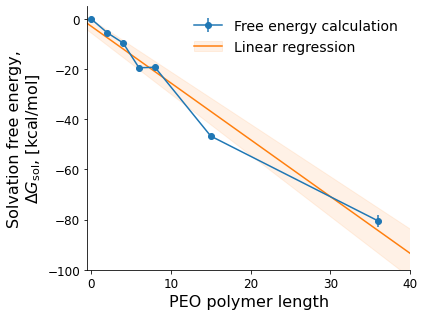

In [17]:
%cd -q $homedir

slvfe = [0]
slvfe_err = [0]

for nmer in nmers:
    with open('Simulations/PEG{}mer/No_salt/ermod.out'.format(nmer)) as f:
        lines = f.readlines()
    f.close()
    for lineNR, line in enumerate(lines):
        if "cumulative average & 95% error for solvation free energy" in line:
            slvfe.append(float(lines[lineNR+10].split()[1]))
            slvfe_err.append(float(lines[lineNR+10].split()[2]))
            break
            

fig, ax = plt.subplots(figsize=(6,4.5))
sims = ax.errorbar([0]+nmers, slvfe, yerr=slvfe_err, marker='o')

ax.set_xlabel('PEO polymer length', fontsize=16)
ax.set_ylabel('Solvation free energy,\n$\Delta G_{\mathrm{sol}}$, [kcal/mol]', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

s = stats.linregress(np.array([0]+nmers), slvfe)
print('Linear statistics:\nSlope: {:.3f} ± {:.3f} kcal/mol/monomer.\nIntercept: {:.3f} ± {:.3f} kcal/mol.\nR²: {:.4f}\np-value: {:e}'.format(s.slope, s.stderr, s.intercept, s.intercept_stderr, s.rvalue**2, s.pvalue))
linregress = ax.plot(np.arange(-1, 50, 0.1), s.intercept+np.arange(-1, 50, 0.1)*s.slope)
linregress_err = ax.fill_between(np.arange(-1, 50, 0.1), y1=(s.intercept+s.intercept_stderr)+np.arange(-1, 50, 0.1)*(s.slope+s.stderr),
                                                        y2=(s.intercept-s.intercept_stderr)+np.arange(-1, 50, 0.1)*(s.slope-s.stderr),
                             color='C1', alpha=0.1)

leg = ax.legend([sims, (linregress[0], linregress_err)], ['Free energy calculation', 'Linear regression'],
                loc='upper right', frameon=False, fontsize=14)

ax.set_xlim(-0.5, 40)
ax.set_ylim(-100, 5)

fig.tight_layout()
fig.savefig('Figures/PEG_polymerlength.pdf', bbox_inches='tight')

### Radius of Gyration (Conformational ensemble in vacuum and solution)

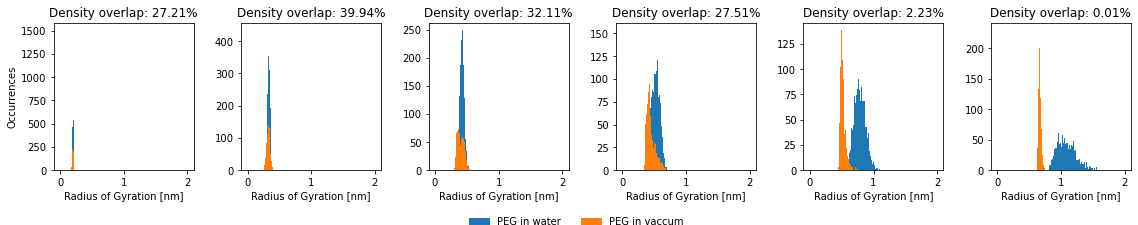

In [18]:
fig, axes = plt.subplots(ncols=len(nmers), figsize=(16,3))

bins = np.arange(0, 2, 0.001)

for i, nmer in enumerate(nmers):
    mol = pmd.load_file('Simulations/PEG{nmer}mer/Solute/PEG_{nmer}_vacuum.top'.format(nmer=nmer),
                        xyz='Simulations/PEG{nmer}mer/Solute/PEG_{nmer}_vacuum.pdb'.format(nmer=nmer))
    
    masses = []
    for atom in mol.atoms:
        masses.append(atom.mass)
    
    traj = md.load_xtc('Simulations/PEG{nmer}mer/No_salt/trajectory_sol.xtc'.format(nmer=nmer),
                       top='Simulations/PEG{nmer}mer/No_salt/PEG_{nmer}_No_salt_sol.pdb'.format(nmer=nmer))
    traj.remove_solvent(inplace=True)
    rg = md.compute_rg(traj, masses=np.array(masses))
    solvated_density = axes[i].hist(rg, color='C0', bins=bins)
    
    traj = md.load_xtc('Simulations/PEG{nmer}mer/Solute/trajectory.xtc'.format(nmer=nmer),
                       top='Simulations/PEG{nmer}mer/Solute/PEG_{nmer}_vacuum.pdb'.format(nmer=nmer))
    rg = md.compute_rg(traj, masses=np.array(masses))
    vacuum_density = axes[i].hist(rg, color='C1', bins=bins)
    
    
    axes[i].set_xlabel('Radius of Gyration [nm]')
    shared_density = np.sum(np.minimum(solvated_density[0], vacuum_density[0]))
    axes[i].set_title('Density overlap: {:.2f}%'.format(shared_density/np.sum(np.maximum(solvated_density[0], vacuum_density[0]))*100))

axes[0].set_ylabel('Occurrences')
c0 = mpatches.Patch(color='C0', label='PEG in water')
c1 = mpatches.Patch(color='C1', label='PEG in vaccum')
lgd = fig.legend(handles=[c0, c1], loc='lower center', ncol=2, frameon=False, bbox_to_anchor=(0.5, -0.05))
fig.subplots_adjust(bottom=0.25)

fig.tight_layout()
fig.savefig('Figures/Rg_Soln_Vacuum_ensemble.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')